In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (confusion_matrix, 
                             classification_report, 
                             precision_score, recall_score, 
                             accuracy_score, f1_score)
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.preprocessing import PolynomialFeatures
import seaborn as sns
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
import statistics

%run -i "functions/split_scale.py"
%run -i "functions/report.py"

In [2]:
data = pd.read_csv('data/student_data.csv')
data.drop('Unnamed: 0', axis= 1, inplace= True)

X = data.drop('X4EVERDROP', axis= 1)
target = data['X4EVERDROP']
bg_data = data[['X1PAREDU', 'X1PARPATTERN', 'X1HHNUMBER', 
                'X1FAMINCOME', 'X1POVERTY', 'X1POVERTY130', 
                'X1POVERTY185', 'Parent?', 'X1SEX', 
                'X1HISPANIC', 'X1WHITE', 'X1BLACK', 
                'X1LOCALE', 'X1REGION']]
bg_data = pd.get_dummies(bg_data)
plan_data = data[['X1STUEDEXPCT', 'S1SUREHSGRAD', 
                  'S1ABILITYBA', 'S1SCHWASTE', 
                  'S1GOODGRADES', 'S1PAYOFF', 
                  'S1GETINTOCLG', 'S1AFFORD', 
                  'S1WORKING', 'S1PLAN', 'S1BAAGE30', 
                  'S1FYNOTSURE']]
plan_data = pd.get_dummies(plan_data)
emo_data = data[['X1PAREDEXPCT', 'S1NOTALKCLG', 'S1NOTALKJOB', 
                 'S1NOTALKPRB', 'FRNDGOODSTUD', 'S1SAFE', 
                 'S1PROUD', 'S1TALKPROB']]
emo_data = pd.get_dummies(emo_data)
aca_data = data[['X3TGPA9TH', 'CLSPREP', 'HRSHOMEWRK', 
                 'S1HRACTIVITY', 'S1HRWORK', 'HRSSOCIAL', 
                 'HRSTECH']]
aca_data = pd.get_dummies(aca_data)
serv_data = data[['MTHPROG', 'HELP', 'C1NOWAY', 'C1GEDPREP', 
                  'MS2HS', 'C1DROPOUT']]
serv_data = pd.get_dummies(serv_data)
couns_data = data[['C1CASELOAD', 'C1GOAL1', 'C1CLGPREP', 
                   'C1WORKFORCE']]
couns_data = pd.get_dummies(couns_data)
cc_data = data[['X3ATTENDCTE', 'JOBPROG', 'COUNSMEET', 
                'CPORG', 'CLGPROG']]
cc_data = pd.get_dummies(cc_data)
X = pd.get_dummies(X)

### Split and Scale the Data

In [3]:
X_train, X_test, y_train, y_test = split_scale(X)

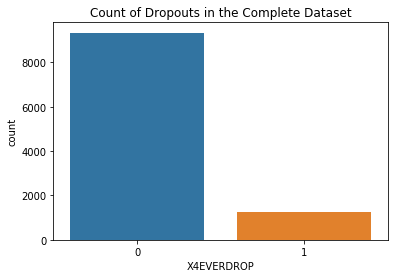

In [4]:
sns.countplot(x= 'X4EVERDROP', data= data)
plt.title('Count of Dropouts in the Complete Dataset')
plt.savefig('figures/dropcount.png');

In [5]:
data['X4EVERDROP'].value_counts()

0    9342
1    1276
Name: X4EVERDROP, dtype: int64

# Model Selection
#### Logistic Regression

In [6]:
logreg = LogisticRegression(solver= 'liblinear', 
                            class_weight= 'balanced')
log_pred = report(logreg)

Confusion Matrix

[[1481  408]
 [  64  171]]

Classification Report

              precision    recall  f1-score   support

           0       0.96      0.78      0.86      1889
           1       0.30      0.73      0.42       235

    accuracy                           0.78      2124
   macro avg       0.63      0.76      0.64      2124
weighted avg       0.89      0.78      0.81      2124



In [7]:
log_bag = BaggingClassifier(logreg, n_estimators = 20, 
                            max_samples = .8)
log_bag_pred = report(log_bag)

Confusion Matrix

[[1498  391]
 [  71  164]]

Classification Report

              precision    recall  f1-score   support

           0       0.95      0.79      0.87      1889
           1       0.30      0.70      0.42       235

    accuracy                           0.78      2124
   macro avg       0.63      0.75      0.64      2124
weighted avg       0.88      0.78      0.82      2124



#### K Nearest Neighbors

In [8]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(weights= 'distance', 
                           n_neighbors= 2)
knn_pred = report(knn)

Confusion Matrix

[[1751  138]
 [ 173   62]]

Classification Report

              precision    recall  f1-score   support

           0       0.91      0.93      0.92      1889
           1       0.31      0.26      0.29       235

    accuracy                           0.85      2124
   macro avg       0.61      0.60      0.60      2124
weighted avg       0.84      0.85      0.85      2124



#### Naive Bayes

In [9]:
from sklearn.naive_bayes import BernoulliNB
nb = BernoulliNB()
nb_pred = report(nb)

Confusion Matrix

[[1545  344]
 [  91  144]]

Classification Report

              precision    recall  f1-score   support

           0       0.94      0.82      0.88      1889
           1       0.30      0.61      0.40       235

    accuracy                           0.80      2124
   macro avg       0.62      0.72      0.64      2124
weighted avg       0.87      0.80      0.82      2124



#### Decision Tree

In [10]:
tree = DecisionTreeClassifier()
tree_pred = report(tree)

Confusion Matrix

[[1699  190]
 [ 153   82]]

Classification Report

              precision    recall  f1-score   support

           0       0.92      0.90      0.91      1889
           1       0.30      0.35      0.32       235

    accuracy                           0.84      2124
   macro avg       0.61      0.62      0.62      2124
weighted avg       0.85      0.84      0.84      2124



In [11]:
params = {'criterion':['gini', 'entropy'], 
          'splitter':['best', 'random'], 
          'max_depth':[10, 50, 100], 
          'min_samples_split':[2, 10, 20], 
          'class_weight':[None, 'balanced']}
gs_tree= GridSearchCV(DecisionTreeClassifier(), params, cv=3, 
                      scoring= 'recall')
gs_tree_pred = report(gs_tree)

Confusion Matrix

[[1473  416]
 [  93  142]]

Classification Report

              precision    recall  f1-score   support

           0       0.94      0.78      0.85      1889
           1       0.25      0.60      0.36       235

    accuracy                           0.76      2124
   macro avg       0.60      0.69      0.61      2124
weighted avg       0.86      0.76      0.80      2124



#### Bagging Classifier

In [12]:
tree = DecisionTreeClassifier(class_weight= 'balanced', 
                              max_depth= 2)
tree_bag = (BaggingClassifier(tree))
tree_bag_pred = report(tree_bag)

Confusion Matrix

[[1555  334]
 [  83  152]]

Classification Report

              precision    recall  f1-score   support

           0       0.95      0.82      0.88      1889
           1       0.31      0.65      0.42       235

    accuracy                           0.80      2124
   macro avg       0.63      0.73      0.65      2124
weighted avg       0.88      0.80      0.83      2124



In [13]:
params = {'n_estimators':[10, 100], 
          'max_features':[1.0, .9]}
gs_tree_bag= GridSearchCV(tree_bag, params, cv=3, 
                      scoring= 'recall')
gs_tree_bag_pred = report(gs_tree_bag)

Confusion Matrix

[[1576  313]
 [  83  152]]

Classification Report

              precision    recall  f1-score   support

           0       0.95      0.83      0.89      1889
           1       0.33      0.65      0.43       235

    accuracy                           0.81      2124
   macro avg       0.64      0.74      0.66      2124
weighted avg       0.88      0.81      0.84      2124



#### AdaBoost

In [14]:
ada = AdaBoostClassifier()
ada_tree_pred = report(ada)

Confusion Matrix

[[1850   39]
 [ 163   72]]

Classification Report

              precision    recall  f1-score   support

           0       0.92      0.98      0.95      1889
           1       0.65      0.31      0.42       235

    accuracy                           0.90      2124
   macro avg       0.78      0.64      0.68      2124
weighted avg       0.89      0.90      0.89      2124



In [15]:
ada = AdaBoostClassifier(logreg)
ada_log_pred = report(ada)

Confusion Matrix

[[1474  415]
 [  64  171]]

Classification Report

              precision    recall  f1-score   support

           0       0.96      0.78      0.86      1889
           1       0.29      0.73      0.42       235

    accuracy                           0.77      2124
   macro avg       0.63      0.75      0.64      2124
weighted avg       0.88      0.77      0.81      2124



#### Random Forest

In [16]:
rand_forest = RandomForestClassifier(class_weight='balanced', 
                                     n_estimators= 100)
rand_forest_pred = report(rand_forest)

Confusion Matrix

[[1883    6]
 [ 216   19]]

Classification Report

              precision    recall  f1-score   support

           0       0.90      1.00      0.94      1889
           1       0.76      0.08      0.15       235

    accuracy                           0.90      2124
   macro avg       0.83      0.54      0.55      2124
weighted avg       0.88      0.90      0.86      2124



#### Custom Ensemble
I'll attempt to improve recall of the 'at-risk' class of students by taking the consensus of the three highest performing models by their ability to recall 'at-risk' students.

In [17]:
preds = []
for i in range(0, len(log_pred)):
    preds.append(statistics.mode([log_pred[i], 
                                  ada_log_pred[i], 
                                  nb_pred[i]]))
print(confusion_matrix(y_test, preds))
print(classification_report(y_test, preds))

[[1482  407]
 [  65  170]]
              precision    recall  f1-score   support

           0       0.96      0.78      0.86      1889
           1       0.29      0.72      0.42       235

    accuracy                           0.78      2124
   macro avg       0.63      0.75      0.64      2124
weighted avg       0.88      0.78      0.81      2124



# Analysis
Next, I will seek to gather information about what catergories of data are most predictive of dropout rate. Because the logistic regression was able to recall the highest proportion of drop-out risks I will use this model as a point of comparison, to examine which category of information is most predictive of a HS dropout.

#### Background Data

In [18]:
X_train, X_test, y_train, y_test = split_scale(bg_data)
bg_pred = report(logreg)

Confusion Matrix

[[1321  568]
 [  78  157]]

Classification Report

              precision    recall  f1-score   support

           0       0.94      0.70      0.80      1889
           1       0.22      0.67      0.33       235

    accuracy                           0.70      2124
   macro avg       0.58      0.68      0.57      2124
weighted avg       0.86      0.70      0.75      2124



#### Student Plans and Attitudes

In [19]:
X_train, X_test, y_train, y_test = split_scale(plan_data)
plan_pred = report(logreg)

Confusion Matrix

[[1405  484]
 [  85  150]]

Classification Report

              precision    recall  f1-score   support

           0       0.94      0.74      0.83      1889
           1       0.24      0.64      0.35       235

    accuracy                           0.73      2124
   macro avg       0.59      0.69      0.59      2124
weighted avg       0.86      0.73      0.78      2124



#### Family/ Peer Support

In [20]:
X_train, X_test, y_train, y_test = split_scale(emo_data)
emo_pred = report(logreg)

Confusion Matrix

[[1413  476]
 [  92  143]]

Classification Report

              precision    recall  f1-score   support

           0       0.94      0.75      0.83      1889
           1       0.23      0.61      0.33       235

    accuracy                           0.73      2124
   macro avg       0.58      0.68      0.58      2124
weighted avg       0.86      0.73      0.78      2124



#### Academic Performance and Time Management

In [21]:
X_train, X_test, y_train, y_test = split_scale(aca_data)
aca_pred = report(logreg)

Confusion Matrix

[[1385  504]
 [  63  172]]

Classification Report

              precision    recall  f1-score   support

           0       0.96      0.73      0.83      1889
           1       0.25      0.73      0.38       235

    accuracy                           0.73      2124
   macro avg       0.61      0.73      0.60      2124
weighted avg       0.88      0.73      0.78      2124



#### Academic Services

In [22]:
X_train, X_test, y_train, y_test = split_scale(serv_data)
serv_pred = report(logreg)

Confusion Matrix

[[1141  748]
 [ 139   96]]

Classification Report

              precision    recall  f1-score   support

           0       0.89      0.60      0.72      1889
           1       0.11      0.41      0.18       235

    accuracy                           0.58      2124
   macro avg       0.50      0.51      0.45      2124
weighted avg       0.81      0.58      0.66      2124



#### Counselor Qualities

In [23]:
X_train, X_test, y_train, y_test = split_scale(couns_data)
couns_pred = report(logreg)

Confusion Matrix

[[1097  792]
 [ 114  121]]

Classification Report

              precision    recall  f1-score   support

           0       0.91      0.58      0.71      1889
           1       0.13      0.51      0.21       235

    accuracy                           0.57      2124
   macro avg       0.52      0.55      0.46      2124
weighted avg       0.82      0.57      0.65      2124



#### College and Career Services

In [24]:
X_train, X_test, y_train, y_test = split_scale(cc_data)
cc_pred = report(logreg)

Confusion Matrix

[[1117  772]
 [ 114  121]]

Classification Report

              precision    recall  f1-score   support

           0       0.91      0.59      0.72      1889
           1       0.14      0.51      0.21       235

    accuracy                           0.58      2124
   macro avg       0.52      0.55      0.47      2124
weighted avg       0.82      0.58      0.66      2124



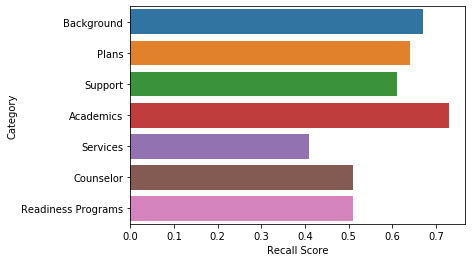

In [25]:
model_recall = pd.DataFrame({'Category': ['Background', 'Plans', 
                                          'Support', 'Academics', 
                                          'Services', 'Counselor', 
                                          'Readiness Programs'], 
                             'Recall Score': [.67, .64, .61, .73, 
                                              .41, .51, .51]})
sns.barplot(y= 'Category', x= 'Recall Score', data= model_recall)
plt.savefig('figures/recall.png');

## Conclusion
Counselors can use academic information to guide their decisions, with confidence. For other categories, metrics that track academic success may be more predictive of desired outcomes. 